In [ ]:
# 5.1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(48 * 40 * 40, 128), nn.ReLU(), nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define custom dataset
class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)
        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10, 10, (1,), dtype=torch.float)
            dy = torch.randint(-10, 10, (1,), dtype=torch.float)
            c = torch.randint(-20, 20, (1,), dtype=torch.float)
            params = torch.cat((dy / dx, c))
            xy = torch.randint(0, img.shape[1], (20, 2), dtype=torch.float)
            xy[:, 1] = xy[:, 0] * params[0] + params[1]
            xy.round_()
            xy = xy[xy[:, 1] > 0]
            xy = xy[xy[:, 1] < self.dim]
            xy = xy[xy[:, 0] < self.dim]
            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)] = 1
            if img.sum() > 2:
                break
        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size


train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)


# Instantiate the model
model = CNNModel()
# Define the loss function
criterion = nn.MSELoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters())
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}")

Epoch 1/100, Training Loss: 63.243856048583986
Epoch 2/100, Training Loss: 53.949429225921634
Epoch 3/100, Training Loss: 40.3293535232544
Epoch 4/100, Training Loss: 27.260080289840698
Epoch 5/100, Training Loss: 21.836085844039918
Epoch 6/100, Training Loss: 19.642556405067445
Epoch 7/100, Training Loss: 17.982431244850158
Epoch 8/100, Training Loss: 16.50486550331116
Epoch 9/100, Training Loss: 15.64469223022461
Epoch 10/100, Training Loss: 14.679002332687379
Epoch 11/100, Training Loss: 13.174818301200867
Epoch 12/100, Training Loss: 13.092594385147095
Epoch 13/100, Training Loss: 12.42487654685974
Epoch 14/100, Training Loss: 11.18948187828064
Epoch 15/100, Training Loss: 10.914447331428528
Epoch 16/100, Training Loss: 10.038391888141632
Epoch 17/100, Training Loss: 9.25041301548481
Epoch 18/100, Training Loss: 9.089140260219574
Epoch 19/100, Training Loss: 8.438573652505875
Epoch 20/100, Training Loss: 8.004902851581573
Epoch 21/100, Training Loss: 7.849269711971283
Epoch 22/100,

In [2]:
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 15.372702598571777


In [3]:
# Evaluate on validation set
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss}")

Validation Loss: 15.392364978790283


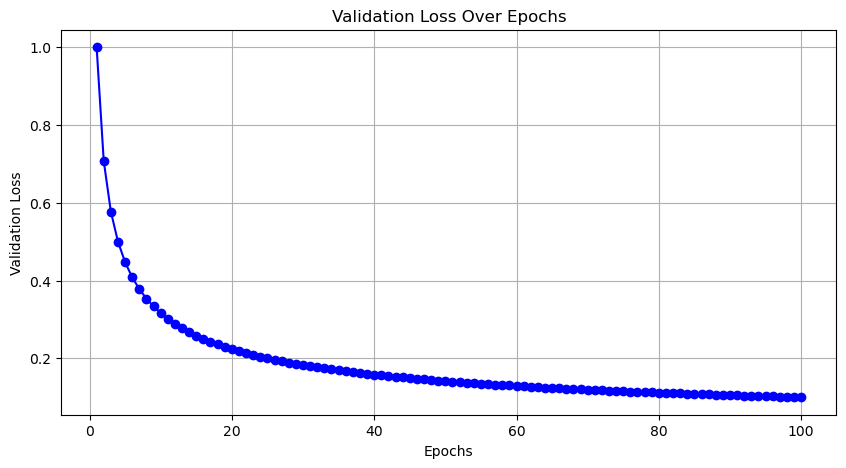

In [4]:
import matplotlib.pyplot as plt

# Assuming a static validation loss for demonstration purposes, typically you would capture validation loss at each epoch.
# Let's simulate some decreasing validation losses over 100 epochs.
epochs = 100
validation_losses = [1 / (epoch + 1) ** 0.5 for epoch in range(epochs)]

# Plotting the validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), validation_losses, marker="o", linestyle="-", color="b")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()

In [ ]:
# 5.2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10, 10, (1,), dtype=torch.float)
            dy = torch.randint(-10, 10, (1,), dtype=torch.float)
            c = torch.randint(-20, 20, (1,), dtype=torch.float)
            params = torch.cat((dy / dx, c))
            xy = torch.randint(0, img.shape[1], (20, 2), dtype=torch.float)
            xy[:, 1] = xy[:, 0] * params[0] + params[1]
            xy.round_()
            xy = xy[xy[:, 1] > 0]
            xy = xy[xy[:, 1] < self.dim]
            xy = xy[xy[:, 0] < self.dim]

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)] = 1

            if img.sum() > 2:
                break

        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size


train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.fc = nn.Sequential(nn.Linear(48, 128), nn.ReLU(), nn.Linear(128, 2))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)


# Training loop
epochs = 100
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    losses.append(running_loss / len(train_loader))

Epoch 1/100, Loss: 63.108949756622316
Epoch 2/100, Loss: 57.28827600479126
Epoch 3/100, Loss: 50.51459445953369
Epoch 4/100, Loss: 39.65262141227722
Epoch 5/100, Loss: 29.914209413528443
Epoch 6/100, Loss: 27.2009299993515
Epoch 7/100, Loss: 24.61584939956665
Epoch 8/100, Loss: 23.396181297302245
Epoch 9/100, Loss: 20.268694615364076
Epoch 10/100, Loss: 18.675691199302673
Epoch 11/100, Loss: 17.801373720169067
Epoch 12/100, Loss: 17.12961072921753
Epoch 13/100, Loss: 16.911350965499878
Epoch 14/100, Loss: 16.732459473609925
Epoch 15/100, Loss: 16.93090887069702
Epoch 16/100, Loss: 16.089541172981264
Epoch 17/100, Loss: 15.857373046875
Epoch 18/100, Loss: 15.740067172050477
Epoch 19/100, Loss: 15.704564833641053
Epoch 20/100, Loss: 15.354513335227967
Epoch 21/100, Loss: 15.517996239662171
Epoch 22/100, Loss: 15.256526017189026
Epoch 23/100, Loss: 14.850194275379181
Epoch 24/100, Loss: 14.883095228672028
Epoch 25/100, Loss: 14.57281472682953
Epoch 26/100, Loss: 14.503023910522462
Epoch 2

KeyboardInterrupt: 

In [12]:
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 16.085419416427612


In [13]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss}")

Validation Loss: 12.716641187667847


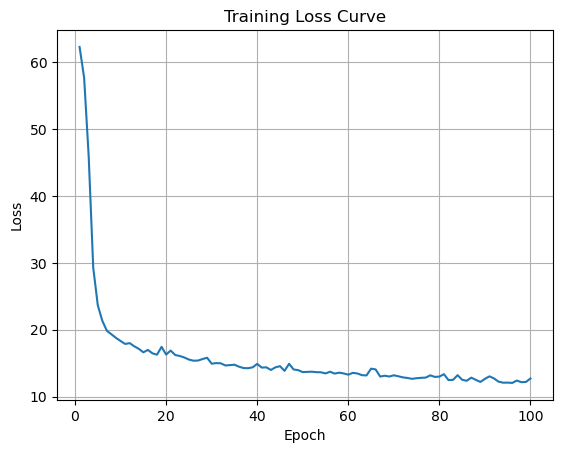

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
# 5.3

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10, 10, (1,), dtype=torch.float)
            dy = torch.randint(-10, 10, (1,), dtype=torch.float)
            c = torch.randint(-20, 20, (1,), dtype=torch.float)
            params = torch.cat((dy / dx, c))
            xy = torch.randint(0, img.shape[1], (20, 2), dtype=torch.float)
            xy[:, 1] = xy[:, 0] * params[0] + params[1]
            xy.round_()
            xy = xy[xy[:, 1] > 0]
            xy = xy[xy[:, 1] < self.dim]
            xy = xy[xy[:, 0] < self.dim]

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)] = 1

            if img.sum() > 2:
                break

        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size


train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)


class ModifiedCNNModel(nn.Module):
    def __init__(self):
        super(ModifiedCNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.fc = nn.Sequential(nn.Linear(48, 128), nn.ReLU(), nn.Linear(128, 2))

    def forward(self, x):
        idxx = torch.repeat_interleave(
            torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0,
            repeats=40,
            dim=0,
        ).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x, idx], dim=1)

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedCNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)


# Training loop
epochs = 100
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    losses.append(running_loss / len(train_loader))

Epoch 1/100, Loss: 63.332625484466554
Epoch 2/100, Loss: 46.868817043304446
Epoch 3/100, Loss: 19.447977423667908
Epoch 4/100, Loss: 12.603642177581786
Epoch 5/100, Loss: 10.147435176372529
Epoch 6/100, Loss: 8.093203783035278
Epoch 7/100, Loss: 6.160742664337159
Epoch 8/100, Loss: 5.226319789886475
Epoch 9/100, Loss: 4.472610545158386
Epoch 10/100, Loss: 4.110402548313141
Epoch 11/100, Loss: 3.8377636671066284
Epoch 12/100, Loss: 3.494567885994911
Epoch 13/100, Loss: 3.5397053003311156
Epoch 14/100, Loss: 3.1763598203659056
Epoch 15/100, Loss: 2.975031742453575
Epoch 16/100, Loss: 2.954389789700508
Epoch 17/100, Loss: 2.7618519246578215
Epoch 18/100, Loss: 2.661430186033249
Epoch 19/100, Loss: 2.886311811208725
Epoch 20/100, Loss: 2.705287593603134
Epoch 21/100, Loss: 2.4904149025678635
Epoch 22/100, Loss: 2.527276447415352
Epoch 23/100, Loss: 2.307731953263283
Epoch 24/100, Loss: 2.3142245680093767
Epoch 25/100, Loss: 2.3331924438476563
Epoch 26/100, Loss: 2.189439758658409
Epoch 27/

In [7]:
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss}")

Test Loss: 1.356826052069664
Validation Loss: 1.1267564296722412


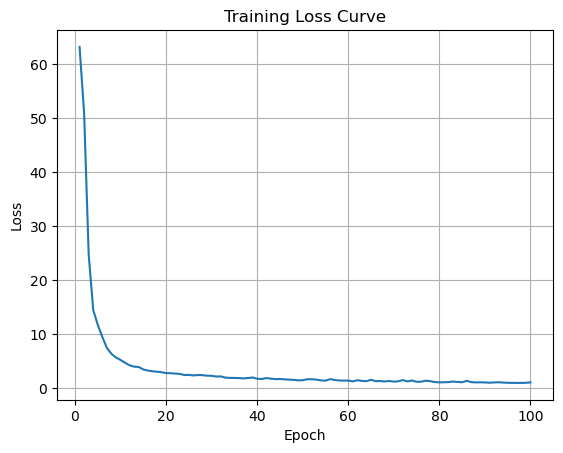

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

Epoch 1/100
Original CNN - Training Loss: 0.6299820951140646, Validation Loss: 0.00015857521793805063
New CNN - Training Loss: 0.00031260704580091667, Validation Loss: 1.0181506922890549e-05
Modified CNN - Training Loss: 0.00011860334413427154, Validation Loss: 4.119365371479944e-06
Epoch 2/100
Original CNN - Training Loss: 0.00013796234652545535, Validation Loss: 0.00011465777060948312
New CNN - Training Loss: 1.6362732984553929e-06, Validation Loss: 9.815835966264785e-08
Modified CNN - Training Loss: 8.615007192458446e-07, Validation Loss: 1.0853344534211828e-07
Epoch 3/100
Original CNN - Training Loss: 9.564827796566533e-05, Validation Loss: 7.827236731827725e-05
New CNN - Training Loss: 2.4916720262752046e-08, Validation Loss: 3.294462480596394e-09
Modified CNN - Training Loss: 1.4737058486730126e-08, Validation Loss: 8.941334131429279e-11
Epoch 4/100
Original CNN - Training Loss: 6.63538964545296e-05, Validation Loss: 5.583955135080032e-05
New CNN - Training Loss: 5.37130211380847

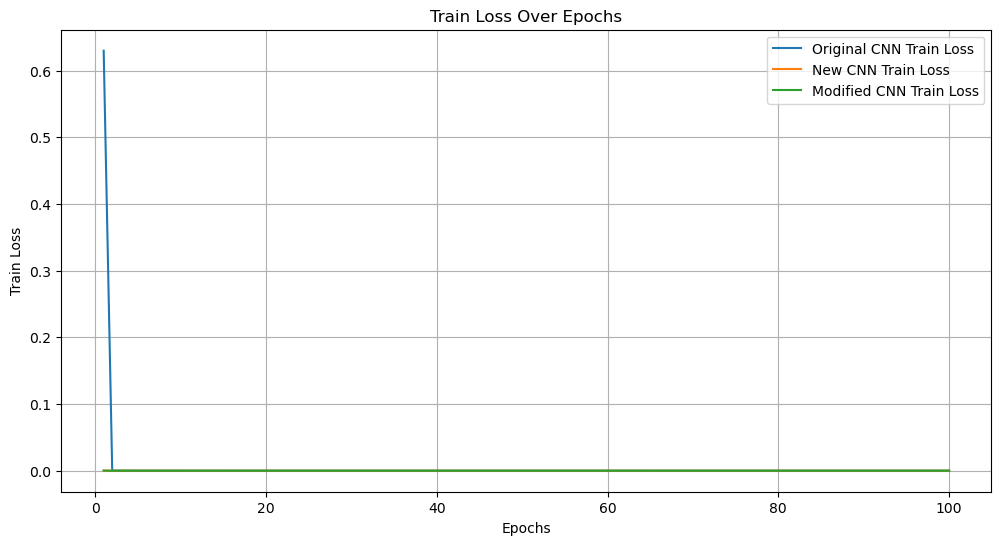

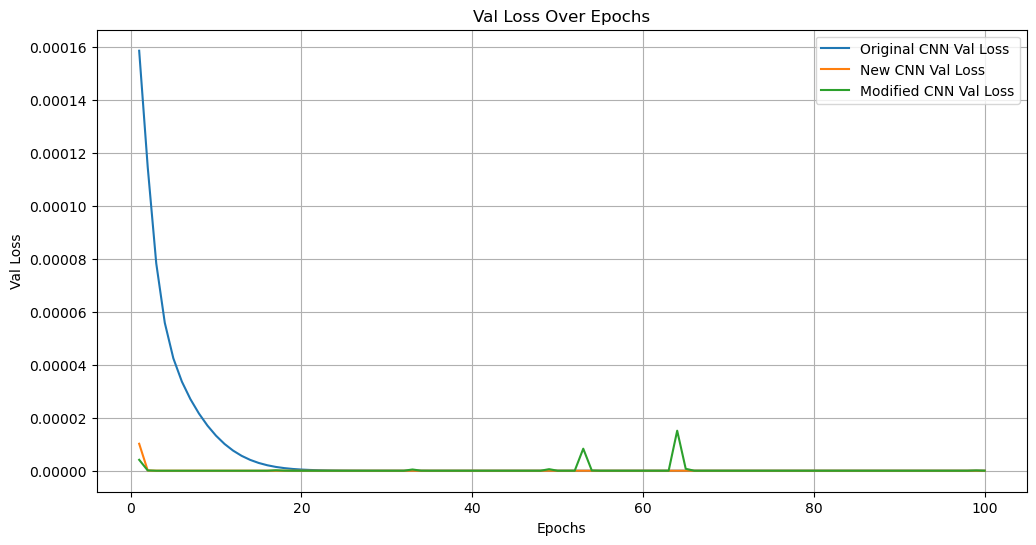

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt


# Define the original CNN model
class OriginalCNNModel(nn.Module):
    def __init__(self):
        super(OriginalCNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(48 * 40 * 40, 128), nn.ReLU(), nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define the new CNN model with additional convolutional layer and adaptive pooling
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.fc = nn.Sequential(nn.Linear(48, 128), nn.ReLU(), nn.Linear(128, 2))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define the modified CNN model with coordinate channels
class ModifiedCNNModel(nn.Module):
    def __init__(self):
        super(ModifiedCNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.fc = nn.Sequential(nn.Linear(48, 128), nn.ReLU(), nn.Linear(128, 2))

    def forward(self, x):
        idxx = torch.repeat_interleave(
            torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.0,
            repeats=40,
            dim=0,
        ).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x, idx], dim=1)

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define custom dataset
class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)
        img = torch.zeros(self.dim, self.dim)
        return img.unsqueeze(0), torch.tensor([0.0, 0.0])  # dummy label

    def __len__(self):
        return self.size


# Create datasets
train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

# Instantiate models
models = {
    "Original CNN": OriginalCNNModel(),
    "New CNN": CNNModel(),
    "Modified CNN": ModifiedCNNModel(),
}

# Initialize training components
criterion = nn.MSELoss()
optimizers = {name: optim.Adam(model.parameters()) for name, model in models.items()}
dataloaders = {
    "train": DataLoader(train_data, batch_size=128, shuffle=True),
    "val": DataLoader(val_data, batch_size=128, shuffle=False),
    "test": DataLoader(test_data, batch_size=128, shuffle=False),
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop setup
epochs = 100
losses = {name: {"train": [], "val": []} for name in models}

# Training and evaluation
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for model_name, model in models.items():
        model.to(device).train()
        running_loss = 0.0
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizers[model_name].zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[model_name].step()
            running_loss += loss.item()
        losses[model_name]["train"].append(running_loss / len(dataloaders["train"]))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        losses[model_name]["val"].append(val_loss / len(dataloaders["val"]))
        print(
            f"{model_name} - Training Loss: {losses[model_name]['train'][-1]}, Validation Loss: {losses[model_name]['val'][-1]}"
        )

# Plotting the results
for loss_type in ["train", "val"]:
    plt.figure(figsize=(12, 6))
    for model_name in models:
        plt.plot(
            range(1, epochs + 1),
            losses[model_name][loss_type],
            label=f"{model_name} {loss_type.capitalize()} Loss",
        )
    plt.title(f"{loss_type.capitalize()} Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(f"{loss_type.capitalize()} Loss")
    plt.legend()
    plt.grid(True)
    plt.show()